# Bajaj the Realtor


In [55]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tabulate import tabulate
import numpy as np
import pickle

In [56]:
def generateRandomDatasets(path, N_PARTITIONS):
    with open(path, "rb") as f:
        dataset = pickle.load(f)

        shuffle_indices = np.random.permutation(np.arange(len(dataset)))

        N_SAMPLES_PER_PARTITION = int(len(dataset) / N_PARTITIONS)

        for i in range(0, N_PARTITIONS):
            data_partition = dataset[
                shuffle_indices[
                    i * N_SAMPLES_PER_PARTITION : (i + 1) * N_SAMPLES_PER_PARTITION
                ]
            ]

            pickle.dump(data_partition, open(f"data/train-dataset-{i+1}.pkl", "wb"))


In [57]:
N_PARTITIONS = 16
MX_DEGREE = 15

generateRandomDatasets("data/train.pkl", N_PARTITIONS)
test_set = pickle.load(open("data/test.pkl", "rb"))


In [58]:
def loadModels(degree):
    datasets = [
        pickle.load(open(f"data/train-dataset-{i}.pkl", "rb"))
        for i in range(1, N_PARTITIONS + 1)
    ]

    models = []

    for dataset in datasets:
        reg = LinearRegression()
        poly = PolynomialFeatures(degree=degree)
        model = reg.fit(poly.fit_transform(dataset[:, 0].reshape(-1, 1)), dataset[:, 1])
        models.append(model)

    return models


In [59]:
degrees = np.arange(15)
biases = []
biases_sq = []
variances = []
irreducible_errors = []
mses = []

for degree in np.arange(1 + MX_DEGREE):
    if degree == 0:
        continue

    models = loadModels(degree)
    predictions = []

    for model in models:
        poly = PolynomialFeatures(degree=degree)
        prediction = model.predict(poly.fit_transform(test_set[:, 0].reshape(-1, 1)))
        predictions.append((prediction))

    new_pred = np.zeros(80)
    foo = np.zeros(80)
    bar = np.zeros(80)

    for j in range(0, 80):
        for i in range(len(predictions)):
            new_pred[j] += predictions[i][j]
            foo[j] += predictions[i][j] ** 2
            bar[j] += np.square(test_set[j, 1] - predictions[i][j])
    
    for j in range(0, 80):
        new_pred[j] /= 16
        foo[j] /= 16
        bar[j] /= 16
    
    predictions = new_pred

    bias = np.mean(np.abs(predictions - test_set[:, 1]))
    bias_sq = np.mean((predictions - test_set[:, 1]) ** 2)

    variance = np.mean(foo - np.square(predictions))

    mse = np.mean(bar)

    ie = (mse - (bias_sq + variance))

    biases.append(bias)
    biases_sq.append(bias_sq)
    variances.append(variance)
    mses.append(mse)
    irreducible_errors.append(ie)
    

dbv = {
    "Degree": np.array(range(1, MX_DEGREE + 1)),
    "Bias": biases,
    "Bias-Squared": biases_sq,
    "Variance": variances,
    "MSE": mses,
    "Irreducible Errors": irreducible_errors,
}

print(tabulate(dbv, headers="keys", tablefmt="fancy_grid"))


╒══════════╤══════════╤════════════════╤════════════╤══════════╤══════════════════════╕
│   Degree │     Bias │   Bias-Squared │   Variance │      MSE │   Irreducible Errors │
╞══════════╪══════════╪════════════════╪════════════╪══════════╪══════════════════════╡
│        1 │ 573.503  │      491681    │    27352.5 │ 519034   │          0           │
├──────────┼──────────┼────────────────┼────────────┼──────────┼──────────────────────┤
│        2 │ 566.844  │      467998    │    50816.7 │ 518814   │          2.91038e-10 │
├──────────┼──────────┼────────────────┼────────────┼──────────┼──────────────────────┤
│        3 │  49.6277 │        4695.53 │    61932.3 │  66627.9 │          1.89175e-10 │
├──────────┼──────────┼────────────────┼────────────┼──────────┼──────────────────────┤
│        4 │  55.4816 │        4425.32 │    95710   │ 100135   │         -1.89175e-10 │
├──────────┼──────────┼────────────────┼────────────┼──────────┼──────────────────────┤
│        5 │  52.9074 │        3

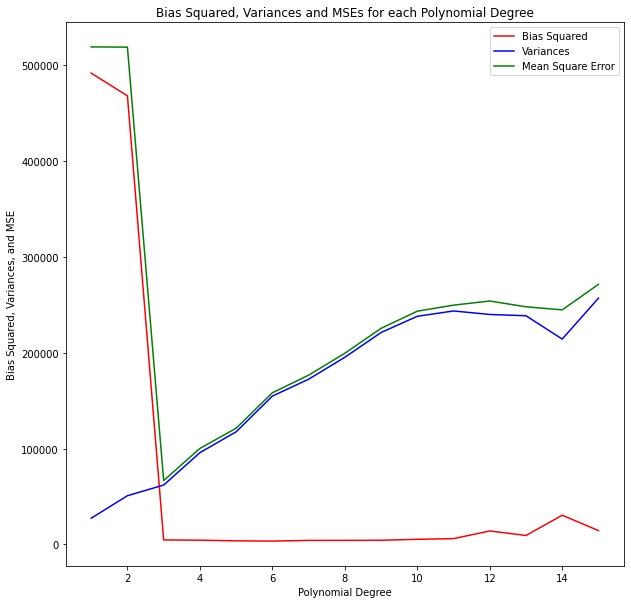

In [60]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, MX_DEGREE + 1), biases_sq, "r", label="Bias Squared")
ax.plot(np.arange(1, MX_DEGREE + 1), variances, "b", label="Variances")
ax.plot(np.arange(1, MX_DEGREE + 1), mses, "g", label="Mean Square Error")
ax.set_xlabel("Polynomial Degree")
ax.set_ylabel("Bias Squared, Variances, and MSE")
ax.set_title("Bias Squared, Variances and MSEs for each Polynomial Degree")
ax.legend()
plt.savefig("bias_squared_and_variances.png")


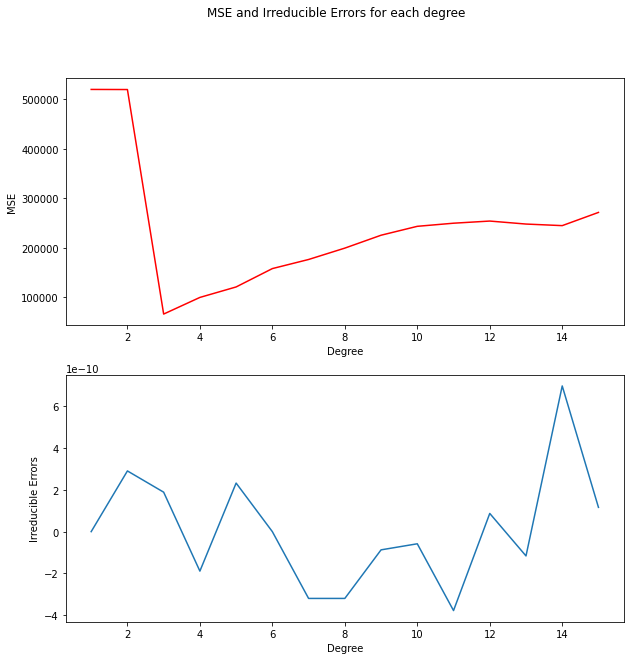

In [63]:
# plot mse and irreducible errors for each degree
plt.rcParams["figure.figsize"] = (10, 10)
fig, axs = plt.subplots(2)
fig.suptitle("MSE and Irreducible Errors for each degree")
axs[0].plot(dbv["Degree"], dbv["MSE"],"r")
axs[0].set_xlabel("Degree")
axs[0].set_ylabel("MSE")
axs[1].plot(dbv["Degree"], dbv["Irreducible Errors"])
axs[1].set_xlabel("Degree")
axs[1].set_ylabel("Irreducible Errors")
# plt.show()
plt.savefig("results.png")



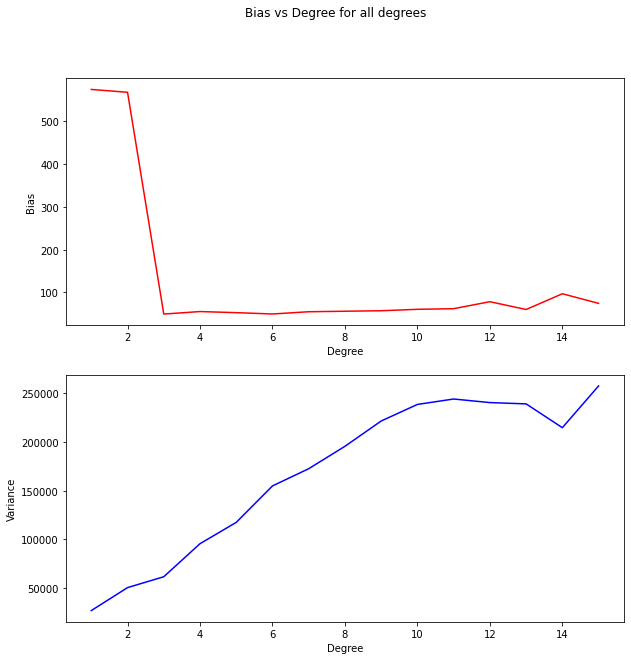

In [64]:
plt.rcParams["figure.figsize"] = (10, 10)
fig, axs = plt.subplots(2)
fig.suptitle("Bias vs Degree for all degrees")
axs[0].plot(dbv["Degree"], dbv["Bias"], "r")
axs[0].set_xlabel("Degree")
axs[0].set_ylabel("Bias")
axs[1].plot(dbv["Degree"], dbv["Variance"], "b")
axs[1].set_xlabel("Degree")
axs[1].set_ylabel("Variance")
plt.savefig("bias_vs_degree.png")